In [1]:
import pickle
from tqdm.notebook import trange
import numpy as np
import matplotlib.pyplot as plt

# Solver for Conditional Estimate

This block contains the implementation of the robust estimator

In [2]:
class Solver(object):
    def mean_estimation_nearest_neighbor(self, xobs, yobs, x0, k):
        # Estimate the median using the nearest neighbor estimator
        nn_num = np.ceil(k).astype(np.int)
        nn_idx = np.argsort(np.abs(xobs-x0))[:nn_num]
        not_nn_idx = np.argsort(np.abs(xobs-x0))[nn_num:]
        return np.mean(yobs[nn_idx])

    def mean_estimation_robust_knn(self, xobs, yobs, x0, k, rho):
        from scipy.optimize import minimize_scalar

        nn_num = np.ceil(k).astype(np.int)
        nn_idx = np.argsort(np.abs(xobs-x0))[:nn_num]
        not_nn_idx = np.argsort(np.abs(xobs-x0))[nn_num:]

        density = np.zeros_like(yobs)
        density[nn_idx] = 1/nn_num

        def objective(beta):
            return density @ np.square(np.abs(yobs - beta) + rho)
        opt_beta = minimize_scalar(objective, bounds=[-1e4,1e4], method='bounded')
        if opt_beta.success:
            return opt_beta.x
        else:
            raise ValueError("optimization fail")
            return None

    def mean_estimation_gaussian_kernel(self, xobs, yobs, x0, bandwidth):
        # Estimate the median using the nearest neighbor estimator
        mindist = np.min(np.square(xobs-x0))/(2 * np.square(bandwidth))
        density = np.exp(mindist-np.square(xobs-x0)/(2 * np.square(bandwidth)))
        return np.sum(yobs * density) / np.sum(density)

    def mean_estimation_robust_gaussian_kernel(self, xobs, yobs, x0, bandwidth, rho):
        from scipy.optimize import minimize_scalar
        mindist = np.min(np.square(xobs-x0))/(2 * np.square(bandwidth))
        density = np.exp(mindist-np.square(xobs-x0)/(2 * np.square(bandwidth)))
        density = density / np.sum(density)

        def objective(beta):
            return density @ np.square(np.abs(yobs - beta) + rho)
        opt_beta = minimize_scalar(objective, bounds=[-1e4,1e4], method='bounded')
        if opt_beta.success:
            return opt_beta.x
        else:
            return 0
            #raise ValueError("optimization fail")
            #return None

    def mean_estimation_epanechnikov_kernel(self, xobs, yobs, x0, bandwidth):
        # Estimate the median using the nearest neighbor estimator
        density = (3/4)*np.max([np.zeros(xobs.shape[0]),1 - np.square((xobs-x0)/bandwidth)],axis = 0)
        if np.isclose(np.sum(density),0):
            return np.mean(yobs)
        else:
            return np.sum(yobs * density) / np.sum(density)
        
    def meWN_1d_cost(self, xobs, yobs, x0, beta, rho, gamma,idx_I1,idx_I2,xDists, alpha = 1):
            y_I1, y_I2 = yobs[idx_I1], yobs[idx_I2]
    #        rho_minus_D_I2 = np.zeros_like(y_I2)
            D_minus_gamma = xDists[idx_I2] - gamma    
            D_minus_gamma[D_minus_gamma<0] = 0
            rho_minus_D_I1 = rho * np.ones_like(y_I1)
            rho_minus_D_I2 = rho - D_minus_gamma

            v_I1 = np.power(np.divide(rho_minus_D_I1,alpha)+np.abs(y_I1-beta),2)
            v_I2 = np.power(np.divide(rho_minus_D_I2,alpha)+np.abs(y_I2-beta),2)
            zmask_I1 = np.ones_like(y_I1)
            zmask_I2 = np.zeros_like(y_I2)
            if len(zmask_I1)==0:
        #        fval = -np.inf
                indexes = np.argsort(-v_I2)
                fval = v_I2[indexes[0]]
                zmask_I2[indexes[0]] = 1
            else:
        #        fval = np.mean(v_I1)
                fval = np.sum(v_I1); count = np.sum(zmask_I1)
                indexes = np.argsort(-v_I2)
                for k in range(len(indexes)):
                    if v_I2[indexes[k]]>np.divide(fval,count):
                        zmask_I2[indexes[k]]=1; count+=1
        #                fval = np.divide(np.sum(v_I1)+np.sum(v_I2[zmask_I2==1]),np.sum(zmask_I1)+np.sum(zmask_I2))
                        fval += v_I2[indexes[k]]
                    else:
                        break
                fval = np.divide(fval,count)

            tmp_I1 = 2*np.multiply(np.sqrt(v_I1),(np.double(beta*np.ones_like(y_I1)>y_I1)-np.double(beta*np.ones_like(y_I1)<y_I1)))
            tmp_I2 = 2*np.multiply(np.sqrt(v_I2),(np.double(beta*np.ones_like(y_I2)>y_I2)-np.double(beta*np.ones_like(y_I2)<y_I2)))
            gradV = np.divide(zmask_I1.dot(tmp_I1)+zmask_I2.dot(tmp_I2),np.sum(zmask_I1)+np.sum(zmask_I2))
            return (fval,gradV)

    def mean_estimation_Winfty_Neighbor_1d(self, xobs, yobs, x0, rho = 1e-2, gamma = 1e-2, alpha = 1, tol = 1e-8, verbose = True):
        #This function uses a bisection algorithm to speed up in the case of 1d y
        yobs = np.array(yobs).flatten()
    #    xDists = np.linalg.norm(xobs-x0,None,0).flatten()
        xDists = np.abs(x0 - xobs)
        xDists = xDists.flatten()    
        idx_I = (xDists <= gamma + rho)
        idx_I1 = (xDists + rho <= gamma)
        idx_I2 = idx_I & (~idx_I1)
        y_I = yobs[idx_I]
        if len(y_I)==0:
            return yobs[np.argsort(xDists)[0]]
        beta_range = np.array([y_I.min(0)-np.divide(rho,alpha), y_I.max(0)+np.divide(rho,alpha)]).flatten()
        best_beta = []; best_fval = np.inf
        while (beta_range[1]-beta_range[0]>tol) or (best_fval==np.inf):
            beta = np.mean(beta_range)
            (fval,gradV) = self.meWN_1d_cost(xobs, yobs, x0, beta, rho, gamma,idx_I1,idx_I2,xDists,alpha)
            if fval<best_fval:
                best_beta=beta; best_fval = fval;
            if gradV>0:
                beta_range[1]=beta
            else:
                beta_range[0]=beta
        return best_beta

    def l2_cost_min_rho(self, xobs, x0, epsilon):
        ntrain = xobs.shape[0] 
        ntransport = np.floor(ntrain * epsilon).astype(np.int)
        sorted_dist = np.sort(np.square(xobs - x0))
        res = np.sum(sorted_dist[:ntransport]) / ntrain
        res += (ntrain * epsilon - ntransport) * sorted_dist[ntransport] / ntrain
        return res

    def l1_cost_min_rho(self, xobs, x0, epsilon):
        ntrain = xobs.shape[0] 
        ntransport = np.floor(ntrain * epsilon).astype(np.int)
        sorted_dist = np.sort(np.abs(xobs - x0))
        res = np.sum(sorted_dist[:ntransport]) / ntrain
        res += (ntrain * epsilon - ntransport) * sorted_dist[ntransport] / ntrain
        return res

# Hyper-parameter grids for conditional estimation

Setting hyperparameters for each methods

In [3]:
class Cv_Setting(object):
    def __init__(self):
        self.k_nn_list = [1,3,5,7,8,9,10,11,12,13,14,15,20]
        self.gamma_k_nn_list = [1,2,3,4,5,6,8,10,12,15]
        self.rho_ratio_list = [1.99526231e-03, 3.98107171e-03,
                               7.94328235e-03, 1.58489319e-02, 
                               3.16227766e-02, 6.30957344e-02,1.25892541e-01]
        self.rho_list = [0, 1.99526231e-03, 3.98107171e-03,
                         7.94328235e-03, 1.58489319e-02, 
                         3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
                         2.51188643e-01, 5.01187234e-01, 1.00000000e+00]
        self.bw_gaussian_list = np.logspace(-3.0, -0.0, num=20)
        self.bw_epanech_list = np.logspace(-3.0, -0.0, num=20)

# Generator for random variable X

In [4]:
def x_generator(lb, ub, p, size):
    n = np.ceil((1+1/p)*size).astype(np.int)
    x = np.random.rand(n)
    torf = (np.random.rand(n) <= p)
    middle_idx = (x >= lb) & (x <= ub) & (torf)
    xret = x[(x < lb) | (x > ub) | middle_idx]
    return xret[:size]

# i.i.d. Noise Generator

In [5]:
def noise_generator(ntrain, noise_type):
    if noise_type == "Bernoulli":
        return (2*rand.binomial(1, 0.5, ntrain)-1)
    if noise_type == "Asym_Bernoulli":
        p =  0.95
        xx = rand.binomial(1, 0.95, ntrain)
        x = np.zeros_like(xx)
        x[xx == 1] = 1
        x[xx == 0] = -(1/(1-p) - 1)
        return 
    if noise_type == "Gaussian":
        return rand.randn(ntrain)
    if noise_type == "Uniform":
        return np.sqrt(3)*(2*rand.rand(ntrain) - 1)
    if noise_type == "Asym_Uniform":
        indicators = rand.binomial(1, 2/3, ntrain)
        return (indicators*rand.rand(ntrain)+(indicators-1)*2*rand.rand(ntrain))/np.sqrt(2/3)
    if noise_type == "ChiSquare":
        return ((2*rand.binomial(1, 0.5, ntrain)-1) * rand.chisquare(1,ntrain)) / np.sqrt(3)
    if noise_type == "TrancateGaussian1":
        noise = np.max([-1*np.ones(ntrain), rand.randn(ntrain)], axis = 0)
        noise = np.min([1*np.ones(ntrain), noise], axis = 0)
        return noise
    if noise_type == "TrancateGaussian2":
        noise = np.max([-2*np.ones(ntrain), rand.randn(ntrain)], axis = 0)
        noise = np.min([2*np.ones(ntrain), noise], axis = 0)
        return noise

# Function for leave-one-out Cross Validation

In [6]:
def MISE_local_cross_validation(xobs, yobs, x0_list, cv_setting, plot = False):
    # unpack hyper-parameter lists from cv_setting
    k_nn_list = cv_setting.k_nn_list
    gamma_k_nn_list = cv_setting.gamma_k_nn_list
    rho_ratio_list = cv_setting.rho_ratio_list
    rho_list = cv_setting.rho_list
    bw_gaussian_list = cv_setting.bw_gaussian_list
    bw_epanech_list = cv_setting.bw_epanech_list
    
    # list to save result for cross validation
    nn_bias_list = np.zeros((len(xobs), len(k_nn_list)))
    robust_nn_bias_list = np.zeros((len(xobs), len(k_nn_list), len(rho_list)))
    Winfty_bias_list = np.zeros((len(xobs), len(gamma_k_nn_list), len(rho_ratio_list)))
    gaussian_bias_list = np.zeros((len(xobs), len(bw_gaussian_list)))
    robust_gaussian_bias_list = np.zeros((len(xobs), len(bw_gaussian_list), len(rho_list)))
    epanech_bias_list = np.zeros((len(xobs), len(bw_epanech_list)))
    num_exp = len(xobs)
    
    for i in trange(len(xobs), desc = "inner", leave = False):
        xtrain = np.append(xobs[:i],xobs[(i+1):])
        ytrain = np.append(yobs[:i],yobs[(i+1):])
        
        xtest = xobs[i]
        ytest = yobs[i]
        
        if xtest < lb or xtest > ub:
            # we only do cross validation when xtest is in the interval of interest: [lb,ub]
            continue
        
        for k_nn_id in range(len(k_nn_list)):
            k_nn = k_nn_list[k_nn_id]
            nn_bias_list[i, k_nn_id] = (
                solver.mean_estimation_nearest_neighbor(xtrain, ytrain, xtest, k_nn) - ytest) 
            
        for j, knn in enumerate(k_nn_list):
            for k, rho in enumerate(rho_list):
                robust_nn_bias_list[i,j,k] = (
                    solver.mean_estimation_robust_knn(xtrain, ytrain, xtest, knn, rho)
                        - ytest)
            
        for j in range(len(gamma_k_nn_list)):
            for k in range(len(rho_ratio_list)):
                gamma_k_nn = gamma_k_nn_list[j]
                rho_ratio = rho_ratio_list[k]
                gamma = np.sort(np.abs(xtrain - xtest))[gamma_k_nn]
                rho = rho_ratio*gamma
                Winfty_bias_list[i,j,k] = (
                solver.mean_estimation_Winfty_Neighbor_1d(xtrain, ytrain, x0 = xtest, rho = rho, gamma = gamma)
                    - ytest)
                
        for gaussian_id in range(len(bw_gaussian_list)):
            bw = bw_gaussian_list[gaussian_id]
            gaussian_bias_list[i, gaussian_id] = (
                solver.mean_estimation_gaussian_kernel(xtrain, ytrain, xtest, bw) - ytest)
        
        for j, bw in enumerate(bw_gaussian_list):
            for k, rho in enumerate(rho_list):
                robust_gaussian_bias_list[i,j,k] = (
                    solver.mean_estimation_robust_gaussian_kernel(xtrain, ytrain, xtest, bw, rho)
                        - ytest)
            
        for epanech_id in range(len(bw_epanech_list)):
            bw2 = bw_epanech_list[epanech_id]
            epanech_bias_list[i, epanech_id] = (
                solver.mean_estimation_epanechnikov_kernel(xtrain, ytrain, xtest, bw2) - ytest)
    # Compute mean-squared error for CV
    k_nn_mean_squared_loss_cv = np.mean(np.square(nn_bias_list), axis = 0, keepdims = False)
    robust_k_nn_mean_squared_loss_cv = np.mean(np.square(robust_nn_bias_list), axis = 0, keepdims = False)
    #k_nn_std_squared_loss_cv = np.std(np.square(nn_bias_list), axis = 0, keepdims = False) / np.sqrt(num_exp)
    Winfty_mean_squared_loss_cv = np.mean(np.square(Winfty_bias_list), axis = 0, keepdims = False)
    #Winfty_std_squared_loss = np.std(np.square(Winfty_bias_list), axis = 0, keepdims = False) / np.sqrt(num_exp)
    gaussian_mean_squared_loss_cv = np.mean(np.square(gaussian_bias_list), axis = 0, keepdims = False)
    robust_gaussian_mean_squared_loss_cv = np.mean(np.square(robust_gaussian_bias_list), axis = 0, keepdims = False)
    #gaussian_std_squared_loss_cv = np.std(np.square(gaussian_bias_list), axis = 0, keepdims = False) / np.sqrt(num_exp)
    epanech_mean_squared_loss_cv = np.mean(np.square(epanech_bias_list), axis = 0, keepdims = False)
    #epanech_std_squared_loss_cv = np.std(np.square(epanech_bias_list), axis = 0, keepdims = False) / np.sqrt(num_exp)
    
    # pick the best hyper-parameter
    gamma_k_nn_idx = np.nanargmin(np.min(Winfty_mean_squared_loss_cv, axis = 1))
    robust_knn_idx = np.nanargmin(np.min(robust_k_nn_mean_squared_loss_cv, axis = 1))
    robust_bw_idx = np.nanargmin(np.min(robust_gaussian_mean_squared_loss_cv, axis = 1))
    rho_ratio_idx = np.nanargmin(Winfty_mean_squared_loss_cv[gamma_k_nn_idx,:])
    rho_knn_idx = np.nanargmin(robust_k_nn_mean_squared_loss_cv[robust_knn_idx,:])
    rho_gaussian_idx = np.nanargmin(robust_gaussian_mean_squared_loss_cv[robust_bw_idx,:])
    
    best_knn = k_nn_list[np.nanargmin(k_nn_mean_squared_loss_cv)]
    best_robust_knn = k_nn_list[robust_knn_idx]
    best_rho_knn = rho_list[rho_knn_idx]
    best_gamma_k_nn = gamma_k_nn_list[gamma_k_nn_idx]
    best_rho_ratio = rho_ratio_list[rho_ratio_idx]
    best_bw_gaussian = bw_gaussian_list[np.nanargmin(gaussian_mean_squared_loss_cv)]
    best_robust_bw = bw_gaussian_list[robust_bw_idx]
    best_rho_gaussian = rho_list[rho_gaussian_idx]
    best_bw_epanech = bw_epanech_list[np.nanargmin(epanech_mean_squared_loss_cv)]
    best_params = (best_knn, best_robust_knn, best_rho_knn, 
                   best_gamma_k_nn, best_rho_ratio, best_bw_gaussian, 
                   best_robust_bw,best_rho_gaussian, best_bw_epanech)
        
    # create matrix to save the bias for final estimation at different x_0 with the best hyper-parameter
    res_knn_list = np.zeros(len(x0_list))
    res_robust_knn_list = np.zeros(len(x0_list))
    res_Winfty_list = np.zeros(len(x0_list))
    res_gaussian_list = np.zeros(len(x0_list))
    res_robust_gaussian_list = np.zeros(len(x0_list))
    res_epanech_list = np.zeros(len(x0_list))
    # Do estimation at different x_0 with the best hyper-parameter
    for i in range(len(x0_list)):
        x0 = x0_list[i]
        gamma = np.sort(np.abs(xobs - x0))[best_gamma_k_nn]
        rho = best_rho_ratio*gamma
        res_knn_list[i] = (
            solver.mean_estimation_nearest_neighbor(xobs, yobs, x0, best_knn) - f(x0))
        res_robust_knn_list[i] = (
            solver.mean_estimation_robust_knn(xobs, yobs, x0, best_robust_knn, best_rho_knn) - f(x0))
        res_Winfty_list[i] = (
            solver.mean_estimation_Winfty_Neighbor_1d(xobs, yobs, x0 = x0, rho = rho, gamma = gamma)
                    - f(x0))
        res_gaussian_list[i] = (
                solver.mean_estimation_gaussian_kernel(xobs, yobs, x0, best_bw_gaussian) - f(x0))
        res_robust_gaussian_list[i] = (
                solver.mean_estimation_robust_gaussian_kernel(xobs, yobs, x0, best_robust_bw, best_rho_gaussian) - f(x0))
        res_epanech_list[i] = (
                solver.mean_estimation_epanechnikov_kernel(xobs, yobs, x0, best_bw_epanech) - f(x0))
    res = (res_knn_list, res_robust_knn_list, res_Winfty_list,res_gaussian_list, res_robust_gaussian_list, res_epanech_list)
    return best_params, res

# Execute the experiment and save the result

In [ ]:
solver = Solver()
freq = 10
exp_num = 500
noise_std_x = 0
rand = np.random.RandomState(1)
f = lambda x: np.sin(10*x)
lb, ub, p = 0.3, 0.7, 0.3
freq_list = [10]
ntrain_list = [50]
noise_type_list = ["Gaussian"]
noise_std_y_list = [0.1]
for freq in freq_list:
    for ntrain in ntrain_list:
        for noise_type in noise_type_list:
            for noise_std_y in noise_std_y_list:
                print(freq,ntrain,noise_type,noise_std_y)
                best_params_list = []
                res_list = []
                for i in trange(exp_num, desc = "outer"):
                    xtrue = x_generator(lb, ub, p, ntrain)
                    ytrue = f(xtrue)
                    xnoise, ynoise = noise_std_x * rand.randn(ntrain), noise_std_y * noise_generator(ntrain, noise_type)
                    xobs, yobs = xtrue + xnoise, (ytrue + ynoise)
                    x0_list = np.linspace(0.05,0.95,91)
                    best_params, res = MISE_local_cross_validation(xobs, yobs, x0_list, Cv_Setting(), plot = False)
                    best_params_list = best_params_list + [best_params]
                    res_list = res_list + [res]
                pickle.dump((best_params_list, res_list), open( "./Results/local_f_{}_train_{}_noise_{}_{}".format(freq,ntrain,noise_type,noise_std_y), "wb"))

# Code for plot

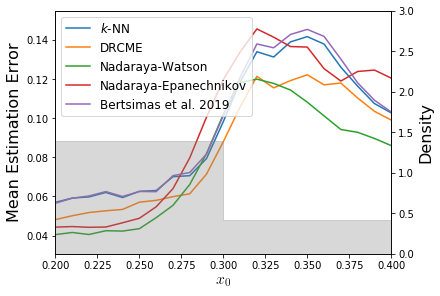

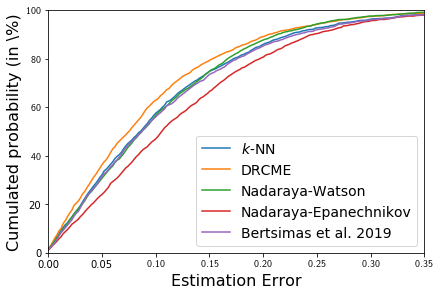

In [7]:
freq = 10
noise_type = "Gaussian"
ntrain = 100
noise_std_y = 0.1
x0_list = np.linspace(0.05,0.95,91)
best_params_list, res_list = pickle.load(
    open( "./Results/local_f_{}_train_{}_noise_{}_{}".format(freq,
                                                            ntrain,noise_type,noise_std_y), "rb" ))

fig, ax = plt.subplots(constrained_layout=True, figsize = (6,4))
ax2 = ax.twinx()
idx = [0,2,3,5,1]
ax.plot(x0_list, np.mean(np.abs(np.array(res_list)), axis = 0)[idx].T)
norm_c = 0.6+0.4*0.3
ax2.fill_between(x = [0.2,0.3,0.3,0.4], y1 = [1/norm_c,1/norm_c,0.3/norm_c,0.3/norm_c], alpha = 0.3, color = 'grey')
ax.legend([r"$k$-NN","DRCME","Nadaraya-Watson","Nadaraya-Epanechnikov",
            "Bertsimas et al. 2019","Probability Density of X"],
          fontsize = 12,loc = "upper left")
ax.set_xlabel("$x_0$", fontsize = 16, usetex=True)
ax.set_ylabel("Mean Estimation Error", fontsize = 16)
ax.set_xlim([0.2,0.4])
ax2.set_ylabel("Density", fontsize = 16)
ax2.set_ylim([0,3])
plt.savefig("./Figures/local_Error.pdf")

fig, ax3 = plt.subplots(constrained_layout=True, figsize = (6,4))
x0_list = np.linspace(0.05,0.95,91)
win_idx = np.where((x0_list>=0.28)&(x0_list<=0.32))
knnBias = np.array([res[0] for res in res_list])[:,win_idx]
robustknnBias = np.array([res[1] for res in res_list])[:,win_idx]
WassBias = np.array([res[2] for res in res_list])[:,win_idx]
ker1Bias = np.array([res[3] for res in res_list])[:,win_idx]
robustker1Bias = np.array([res[4] for res in res_list])[:,win_idx]
ker2Bias = np.array([res[5] for res in res_list])[:,win_idx]
def print_cdf(bias):
    p, x = np.histogram(np.abs(np.reshape(np.abs(bias),(-1,))), bins = np.linspace(0,1,500))
    ax3.plot(x[:-1],100*np.cumsum(p)/np.sum(p))
print_cdf(knnBias)
print_cdf(WassBias)
print_cdf(ker1Bias)
print_cdf(ker2Bias)
print_cdf(robustknnBias)
ax3.set_xlim([0,.35])
ax3.set_ylim([0,100])
estimator_list = ["$\mathit{k}$-NN","DRCME","Nadaraya-Watson","Nadaraya-Epanechnikov",
    "Bertsimas et al. 2019"]
ax3.legend(estimator_list,loc = "lower right",fontsize = 14)
ax3.set_xlabel("Estimation Error", fontsize = 16)
ax3.set_ylabel("Cumulated probability (in \%)", fontsize = 16)
plt.rc('text', usetex=True)
plt.savefig("./Figures/local_cdf.pdf")